In [79]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import copy
import pandas as pd
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


sns.set_context('paper',font_scale=1.2)

In [80]:
import os
os.chdir('/home2/cboscher/code/pastel2.0/results/')

In [81]:
class Plot_Arguments():
    def __init__(self):
        self.epochs = 100
        self.legends = ["Main task - Black box", "Main task - Model Replacement", "Attack success rate - black box",
                        "Attack success rate - model replacement"]
        self.maxy = 110
        self.ylabel = 'Accuracy (%)'
        self.xlabel = 'FL rounds'
        self.colors = ['black',
                       '#339933',
                       '#fdae61',
                       '#d7191c', '#000000', '#B03A2E', '#85C1E9']
        self.patterns = ['x', 'o', 'd', 'v', '^', '<', '>']

In [82]:
import numpy as np

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
def generate_histogram(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False, display_err = True, indices=None, extension="pdf", decimals=2, factor=1, y_scale=None, manual_values = None):

    labels = []
    colors = []
    values = []
    errs = []
    
    for exp in plot_config["data"]:
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        if exp["file_path"] is None:

            values.append(min_y)
            errs.append(0)
        else:
            max_value, std_dev = get_means_average(exp["file_path"],column_name, indices)
            values.append(max_value*factor)
            if display_err:
                errs.append(std_dev*factor)
            else:
                errs.append(0)
        
    if manual_values != None:
        values=manual_values
    # the histogram of the data
    print(values)
    print(errs)
    
    for(x,y) in zip (values, errs):
        print("{} ± {}".format(int(x), int(y)))
    plot_args = Plot_Arguments()
    
 
    new_values = [(value/values[0] -1 )*100 for value in values]
    
    ax = sns.barplot(x = labels,y =values, palette = 'magma_r',yerr=errs, ci=385, capsize=1.5)

    plot_args.ylabel= y_label

    ax.set_ylabel(plot_args.ylabel, fontsize=15)
    
    ax.set_xticklabels(labels = labels, rotation=15)

    num_locations = 1
    hatches = itertools.cycle(['/',  '-', '//', '\\', '', 'o', 'O', '.'])
    for i, bar in enumerate(ax.patches):
        if i % num_locations == 0:
            hatch = next(hatches)
        bar.set_hatch(hatch)

    bar_labels = [(np.round(z,0) if decimals!=0 else np.int(z)) if z != min_y else "" for z in new_values]
    bar_labels = [(("+" + str(int(value)) if value >= 0 else str(int(value)))+ "%") if (value != "") else "" for value in bar_labels]
    bar_labels[0] = "" 
    for i in ax.containers:
        try:
            ax.bar_label(i,bar_labels )
        except:
            pass
    
    new_value = 0.4
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
    
    if y_scale == 'log':
        ax.set_yscale('log')
        ax.set(ylim=(ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
    else:
        ax.set(ylim=(min_y, max_y))

    ax.set_xlabel('')
    ax.set_title('')
    plt.savefig('./figures/{}_{}.{}'.format(plot_config['dataset_name'], experiment_name, extension),bbox_inches='tight')

    plt.show()
    

In [83]:
def generate_xy_plot(plot_config, experiment_name, y_label, column_name, min_y, max_y, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    
    for exp in plot_config["data"]:
        
        if exp["file_path"] is None:
            continue
            
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            values.append(compute_average_per_round(exp["file_path"],column_name))
        else:
            values.append(get_max_avg_value(exp["file_path"],column_name))
    
    
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.ylabel= y_label

    x = range(1, len(values[0]) + 1)
    
    for i in range(len(labels)):
        print(labels[i])
        print(len(values[i]))
        ax.plot(x, values[i], color= colors[i] ,label=labels[i], linewidth=1, marker=markers[i], markersize=6, markevery=5+i)
            
    plt.ylabel(plot_args.ylabel)
    plt.xlabel(plot_args.xlabel)
    change_width(ax, .2)
    # plt.subplots_adjust(top=0.75)
    lgd = ax.legend(ncol=3, loc="lower center", bbox_to_anchor=[0.5, -0.55])
    ax.set_xlim(1, len(values[0])+1)
    ax.set_ylim(0, 100)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

        

In [84]:
def generate_tradeoff_plot(plot_config, experiment_name, x_label, y_label, x_column_name, y_column_name, min_y, max_y, min_x, max_x, average=False):
    
    labels = []
    colors = []
    values = []
    markers = []
    x_values = []
    y_values = []
    
    for exp in plot_config["data"]:
        if exp["file_path"] is None:
            continue
        labels.append(exp["exp_name"])
        colors.append(exp["color"])
        markers.append(exp["symbol"])
        if average:
            x_values.append(get_max_average(exp["file_path"],x_column_name))
            y_values.append(get_max_average(exp["file_path"],y_column_name))
        else:
            x_values.append(get_max_avg_value(exp["file_path"],x_column_name))
            y_values.append(get_max_avg_value(exp["file_path"],y_column_name))

        
    
    x_axis = [x for (x,_) in x_values]
    y_axis = [x for (x,_) in y_values]
    plot_args = Plot_Arguments()
    fig, ax = plt.subplots()
    plot_args.xlabel = x_label
    plot_args.ylabel= y_label
    
    ax = sns.scatterplot(x=x_axis, y= y_axis, hue=labels, style=labels,s=200, palette='magma_r')

    handles, labels  =  ax.get_legend_handles_labels()

    ax.legend(handles, labels,markerscale=1.5)

    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel(x_label)
    if y_sc
    ax.set(ylim=(min_y, max_y), xlim=( min_x, max_x))

    
#     for i, txt in enumerate(labels):
#         ax.annotate(txt, (x_values[i] + 2 , y_values[i] -1), fontsize=8)
    
    plt.savefig('./figures/{}_{}.pdf'.format(plot_config['dataset_name'], experiment_name),bbox_inches='tight')

    plt.show()
    

SyntaxError: invalid syntax (3213992004.py, line 40)

In [85]:
def compute_average_per_round(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return values.to_list()

def compute_average(file_path, column_name):
    return compute_average_per_round(file_path, column_name)[-1]
   
    
def get_means_average(file_path, column_name, indices = None):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    means = []
    
    if indices is not None:

        for column in columns_to_aggregate:
            means.append(data[column][data.index.isin(indices)].mean())
    else:
        for column in columns_to_aggregate:
            print(data[column])
            means.append(data[column].mean())    
    if len(columns_to_aggregate)==1:
        std_dev = data[columns_to_aggregate[0]].std()
    else:
        std_dev = np.std(means)
    print(means)
    return sum(means)/len(means), std_dev

def get_max_values_per_client(file_path, column_name):
    
    data = pd.read_csv(file_path)
    values = []
    
    columns_to_compute = data.columns[data.columns.str.contains(column_name)]
    
    for column in columns_to_compute:
        values.append(max(data[column].to_list()))
        
    return values



def get_max_avg_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].mean(axis=1)
    return sum(values.to_list()[-10:])/10


def get_std_dev_value(file_path, column_name):
    data = pd.read_csv(file_path)
    columns_to_aggregate = data.columns[data.columns.str.contains(column_name)]
    
    values = data[columns_to_aggregate].std(axis=1)
    return values.to_list()[-1]


### Purchase

In [86]:
plot_config = {
                "dataset_name": "costs_state_of_art_purchase",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_purchase.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_purchase.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_purchase.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_purchase.csv",
                            "color": "grey",
                            "symbol" : "^"
                        }
                    
                    ]
                }

0    0.978695
1    1.069366
2    0.988857
Name: client_round_duration_1, dtype: float64
0    0.994620
1    0.956473
2    1.008236
Name: client_round_duration_6, dtype: float64
0    0.988442
1    0.820747
2    0.684125
Name: client_round_duration_4, dtype: float64
0    0.943279
1    0.681968
2    0.931972
Name: client_round_duration_9, dtype: float64
0    0.741847
1    1.055623
2    0.947702
Name: client_round_duration_3, dtype: float64
0    0.701987
1    0.898080
2    0.688539
Name: client_round_duration_8, dtype: float64
0    0.996010
1    1.070849
2    0.696349
Name: client_round_duration_5, dtype: float64
0    0.968647
1    0.768573
2    0.955745
Name: client_round_duration_7, dtype: float64
0    0.954792
1    0.698678
2    0.806817
Name: client_round_duration_2, dtype: float64
0    0.958578
1    1.044066
2    0.984093
Name: client_round_duration_0, dtype: float64
[1.0123060544331868, 0.9864432017008463, 0.8311048348744711, 0.8524064222971598, 0.9150573412577311, 0.7628686428070068,

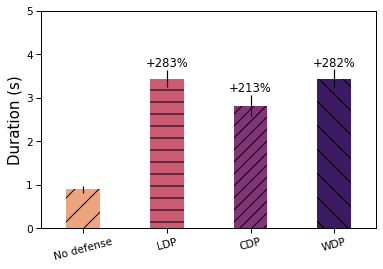

0    0.444029
1    0.654866
2    0.450014
Name: server_aggregation_duration, dtype: float64
[0.5163031419118246]
0    0.457633
1    0.431219
2    0.401317
Name: server_aggregation_duration, dtype: float64
[0.4300564130147298]
0    6.802516
1    6.610983
2    6.701596
Name: server_aggregation_duration, dtype: float64
[6.705031315485637]
0    0.435925
1    0.464085
2    0.299570
Name: server_aggregation_duration, dtype: float64
[0.3998599847157796]
[516.3031419118246, 430.0564130147298, 6705.031315485637, 399.8599847157796]
[120.03666126436389, 28.17559716085, 95.81263144334235, 87.98727220930003]
516 ± 120
430 ± 28
6705 ± 95
399 ± 87


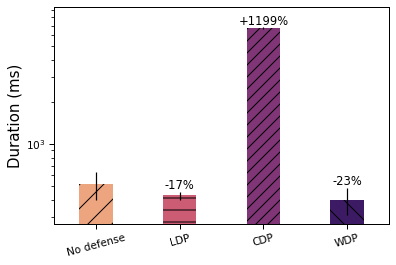

0    0.444029
1    0.654866
2    0.450014
Name: server_aggregation_duration, dtype: float64
[0.5163031419118246]
0    0.457633
1    0.431219
2    0.401317
Name: server_aggregation_duration, dtype: float64
[0.4300564130147298]
0    6.802516
1    6.610983
2    6.701596
Name: server_aggregation_duration, dtype: float64
[6.705031315485637]
0    0.435925
1    0.464085
2    0.299570
Name: server_aggregation_duration, dtype: float64
[0.3998599847157796]
[2195, 9575, 10777, 9575]
[0, 0, 0, 0]
2195 ± 0
9575 ± 0
10777 ± 0
9575 ± 0


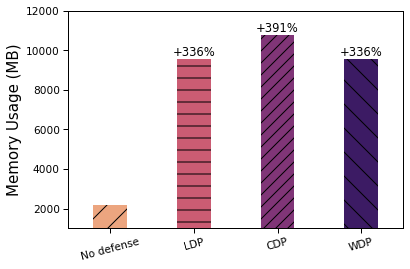

In [76]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 5, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale='log')
values = [2195, 9575, 10777, 9575]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 1000, 12000, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)



In [39]:
plot_config = {
                "dataset_name": "costs_texas",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_texas.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_texas.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_texas.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_texas.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_texas.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    4.229041
1    2.695273
2    2.321358
Name: client_round_duration_8, dtype: float64
0    2.385015
1    1.937963
2    2.586224
Name: client_round_duration_5, dtype: float64
0    2.457986
1    2.741510
2    2.616066
Name: client_round_duration_3, dtype: float64
0    2.742257
1    2.055410
2    2.807228
Name: client_round_duration_4, dtype: float64
0    2.143268
1    2.353565
2    2.287014
Name: client_round_duration_2, dtype: float64
0    2.757056
1    2.629846
2    2.229663
Name: client_round_duration_0, dtype: float64
0    2.592874
1    2.730250
2    2.731823
Name: client_round_duration_6, dtype: float64
0    2.276549
1    2.127670
2    2.265310
Name: client_round_duration_1, dtype: float64
0    2.882797
1    2.750882
2    2.768516
Name: client_round_duration_7, dtype: float64
0    2.175374
1    2.815786
2    2.808634
Name: client_round_duration_9, dtype: float64
[3.081890821456909, 2.303067127863566, 2.60518749554952, 2.53496519724528, 2.261282523473104, 2.5388551553090415, 2.6849

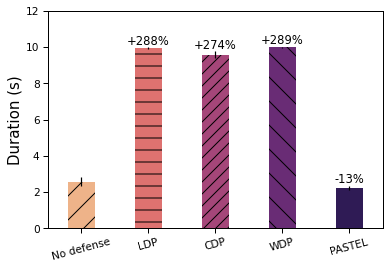

0    0.891620
1    0.739103
2    0.987744
Name: server_aggregation_duration, dtype: float64
[0.8728223641713461]
0    1.043937
1    1.057642
2    1.539908
Name: server_aggregation_duration, dtype: float64
[1.2138289610544841]
0    7.536271
1    6.752278
Name: server_aggregation_duration, dtype: float64
[7.144274353981018]
0    1.043940
1    1.099942
2    1.939909
Name: server_aggregation_duration, dtype: float64
[1.3612637611550449]
0    1.057332
1    1.047551
2    0.918560
Name: server_aggregation_duration, dtype: float64
[1.0078142484029133]
[872.8223641713461, 1213.8289610544841, 7144.274353981018, 1361.263761155045, 1007.8142484029133]
[125.3816323755541, 282.4762143927565, 554.3664335956735, 501.90352246832583, 77.45077503006117]
872 ± 125
1213 ± 282
7144 ± 554
1361 ± 501
1007 ± 77


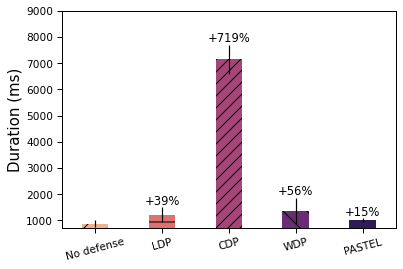

0    0.891620
1    0.739103
2    0.987744
Name: server_aggregation_duration, dtype: float64
[0.8728223641713461]
0    1.043937
1    1.057642
2    1.539908
Name: server_aggregation_duration, dtype: float64
[1.2138289610544841]
0    7.536271
1    6.752278
Name: server_aggregation_duration, dtype: float64
[7.144274353981018]
0    1.043940
1    1.099942
2    1.939909
Name: server_aggregation_duration, dtype: float64
[1.3612637611550449]
0    1.057332
1    1.047551
2    0.918560
Name: server_aggregation_duration, dtype: float64
[1.0078142484029133]
[3473, 32471, 32532, 32471, 3473]
[0, 0, 0, 0, 0]
3473 ± 0
32471 ± 0
32532 ± 0
32471 ± 0
3473 ± 0


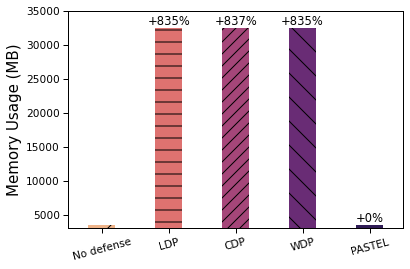

In [44]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 12, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 700, 9000, average=True, decimals=2, factor=1000)
values = [3473, 32471, 32532, 32471, 3473,]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 3000, 35000, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)


In [45]:
plot_config = {
                "dataset_name": "costs_celeba_vgg",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_celeba.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_celeba.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    15.682958
1    12.235976
2    12.318084
Name: client_round_duration_2, dtype: float64
0    12.460927
1    12.318809
2    12.484756
Name: client_round_duration_0, dtype: float64
0    12.369948
1    12.202305
2    12.635035
Name: client_round_duration_1, dtype: float64
0    12.597089
1    12.583635
2    12.211956
Name: client_round_duration_4, dtype: float64
0    12.291652
1    12.561814
2    12.877057
Name: client_round_duration_3, dtype: float64
[13.412339289983114, 12.421497186024984, 12.402429183324179, 12.464226643244425, 12.576841115951538]
0    15.900838
1    15.792905
2    15.341603
Name: client_round_duration_2, dtype: float64
0    13.130492
1    15.634350
2    15.382225
Name: client_round_duration_0, dtype: float64
0    15.704845
1    13.146019
2    15.690430
Name: client_round_duration_1, dtype: float64
0    15.981988
1    15.597358
2    13.389621
Name: client_round_duration_4, dtype: float64
0    15.500854
1    15.550493
2    15.472472
Name: client_round_duration_3, dtyp

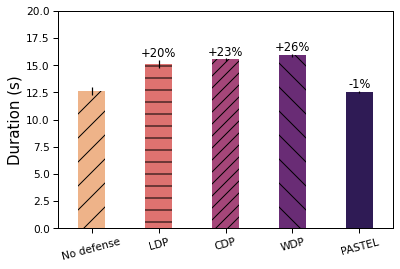

In [46]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 20, average=True, decimals=2)


In [47]:
plot_config = {
                "dataset_name": "costs_celeba_vgg",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_celeba.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs/costs_cdp_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_celeba_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    0.410238
1    0.426576
2    0.400816
Name: server_aggregation_duration, dtype: float64
[0.4125431378682454]
0    0.396963
1    0.398536
Name: server_aggregation_duration, dtype: float64
[0.39774966239929194]
0    27.450460
1    27.441593
2    27.525554
Name: server_aggregation_duration, dtype: float64
[27.472535610198975]
0    0.384289
1    0.391639
2    0.396827
Name: server_aggregation_duration, dtype: float64
[0.3909185727437337]
0    0.415557
1    0.404137
2    0.504325
Name: server_aggregation_duration, dtype: float64
[0.4413398901621501]
[412.5431378682454, 397.74966239929194, 27472.535610198975, 390.9185727437337, 441.3398901621501]
[13.033666843757624, 1.1123396258995153, 46.12855542319328, 6.299968227292965, 54.84509134933595]
412 ± 13
397 ± 1
27472 ± 46
390 ± 6
441 ± 54


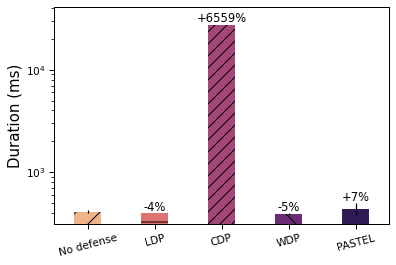

0    0.410238
1    0.426576
2    0.400816
Name: server_aggregation_duration, dtype: float64
[0.4125431378682454]
0    0.396963
1    0.398536
Name: server_aggregation_duration, dtype: float64
[0.39774966239929194]
0    27.450460
1    27.441593
2    27.525554
Name: server_aggregation_duration, dtype: float64
[27.472535610198975]
0    0.384289
1    0.391639
2    0.396827
Name: server_aggregation_duration, dtype: float64
[0.3909185727437337]
0    0.415557
1    0.404137
2    0.504325
Name: server_aggregation_duration, dtype: float64
[0.4413398901621501]
[2753, 7229, 7519, 7229, 2753]
[0, 0, 0, 0, 0]
2753 ± 0
7229 ± 0
7519 ± 0
7229 ± 0
2753 ± 0


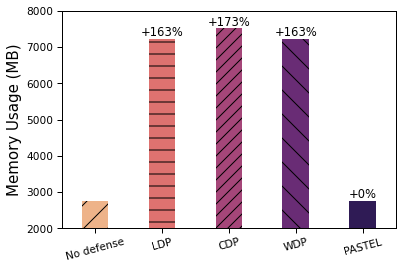

In [52]:
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale='log')
values = [2753, 7229, 7519, 7229, 2753]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 2000, 8000, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)


In [53]:
plot_config = {
                "dataset_name": "costs_celeba_resnet",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_celeba_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_celeba_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    13.473124
1    12.784575
2    12.930078
Name: client_round_duration_2, dtype: float64
0    13.396607
1    12.804037
2    13.401264
Name: client_round_duration_0, dtype: float64
0    12.988116
1    12.874015
2    13.049863
Name: client_round_duration_1, dtype: float64
0    12.862137
1    12.858103
2    12.975374
Name: client_round_duration_4, dtype: float64
0    13.107637
1    13.024871
2    13.231677
Name: client_round_duration_3, dtype: float64
[13.062592109044393, 13.200636068979898, 12.970664660135904, 12.898537794748941, 13.121395031611124]
0    13.421353
1    12.930209
2    13.244331
Name: client_round_duration_2, dtype: float64
0    13.703143
1    13.039358
2    12.875405
Name: client_round_duration_0, dtype: float64
0    13.196291
1    12.823470
2    13.069620
Name: client_round_duration_1, dtype: float64
0    12.985384
1    12.879187
2    13.394282
Name: client_round_duration_4, dtype: float64
0    12.800808
1    12.940670
2    13.108089
Name: client_round_duration_3, dtyp

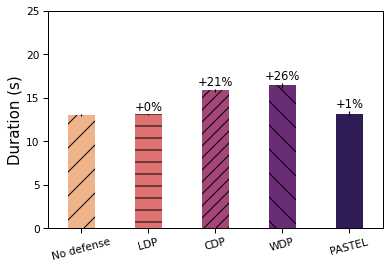

0    0.061421
1    0.062028
2    0.063000
Name: server_aggregation_duration, dtype: float64
[0.06214968363444007]
0    0.054136
1    0.092393
2    0.056194
Name: server_aggregation_duration, dtype: float64
[0.0675741831461588]
0    28.497217
1    28.582286
2    28.097082
Name: server_aggregation_duration, dtype: float64
[28.392194986343384]
0    0.033530
1    0.037649
2    0.040043
Name: server_aggregation_duration, dtype: float64
[0.03707385063171383]
0    0.056593
1    0.054499
2    0.053691
Name: server_aggregation_duration, dtype: float64
[0.054927349090576096]
[62.149683634440066, 67.5741831461588, 28392.194986343384, 37.07385063171383, 54.927349090576094]
[0.7968872833066742, 21.518487875520087, 259.0906627052884, 3.29456923252157, 1.4977545276444608]
62 ± 0
67 ± 21
28392 ± 259
37 ± 3
54 ± 1


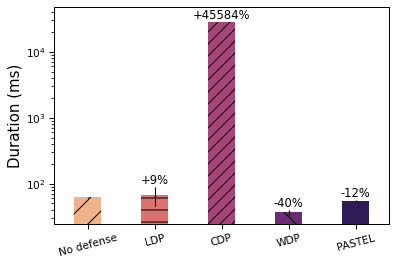

In [55]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 25, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale='log')


In [56]:
plot_config = {
                "dataset_name": "costs_gtsrb_vgg",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_gtsrb_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_gtsrb_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    14.644449
1    14.115714
2    14.430728
Name: client_round_duration_3, dtype: float64
0    14.228725
1    14.132400
2    14.037533
Name: client_round_duration_0, dtype: float64
0    14.529422
1    14.548202
2    14.098273
Name: client_round_duration_4, dtype: float64
0    14.346334
1    14.143389
2    14.283610
Name: client_round_duration_1, dtype: float64
0    14.585486
1    14.170238
2    14.091512
Name: client_round_duration_2, dtype: float64
[14.396963993708292, 14.132886171340942, 14.391965707143148, 14.25777792930603, 14.282412052154541]
0    19.455061
1    19.608696
2    19.364215
Name: client_round_duration_3, dtype: float64
0    19.191345
1    19.272822
2    19.339220
Name: client_round_duration_0, dtype: float64
0    19.270493
1    19.452192
2    19.284454
Name: client_round_duration_4, dtype: float64
0    19.079338
1    19.357976
2    19.495465
Name: client_round_duration_1, dtype: float64
0    15.637328
1    19.410220
2    19.413591
Name: client_round_duration_2, dtype

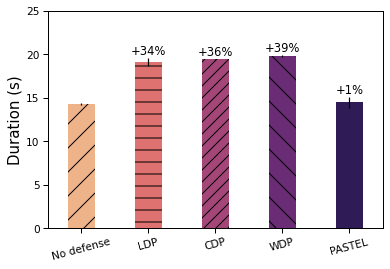

0    0.408518
1    0.403834
2    0.412813
Name: server_aggregation_duration, dtype: float64
[0.40838853518168133]
0    0.404824
1    0.415130
2    0.405972
Name: server_aggregation_duration, dtype: float64
[0.4086416562398291]
0    12.885563
1    12.675286
2    12.418777
Name: server_aggregation_duration, dtype: float64
[12.659875313440958]
0    0.316899
1    0.395820
2    0.400809
Name: server_aggregation_duration, dtype: float64
[0.37117600440979004]
0    0.403289
1    0.528227
2    0.339634
Name: server_aggregation_duration, dtype: float64
[0.42371662457784015]
[408.38853518168133, 408.6416562398291, 12659.875313440958, 371.17600440979004, 423.71662457784015]
[4.490947656136072, 5.648007665835017, 233.77470287879873, 47.07177118381827, 95.94196002221942]
408 ± 4
408 ± 5
12659 ± 233
371 ± 47
423 ± 95


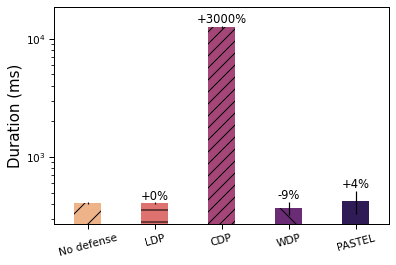

0    0.408518
1    0.403834
2    0.412813
Name: server_aggregation_duration, dtype: float64
[0.40838853518168133]
0    0.404824
1    0.415130
2    0.405972
Name: server_aggregation_duration, dtype: float64
[0.4086416562398291]
0    12.885563
1    12.675286
2    12.418777
Name: server_aggregation_duration, dtype: float64
[12.659875313440958]
0    0.316899
1    0.395820
2    0.400809
Name: server_aggregation_duration, dtype: float64
[0.37117600440979004]
0    0.403289
1    0.528227
2    0.339634
Name: server_aggregation_duration, dtype: float64
[0.42371662457784015]
[6047, 11717, 11735, 11717, 6047]
[0, 0, 0, 0, 0]
6047 ± 0
11717 ± 0
11735 ± 0
11717 ± 0
6047 ± 0


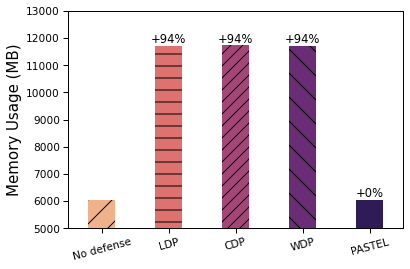

In [57]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 25, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale='log')
values = [6047, 11717, 11735, 11717, 6047]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 5000, 13000, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)


In [ ]:
plot_config = {
                "dataset_name": "costs_gtsrb_resnet",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_gtsrb_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_gtsrb_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

In [ ]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 25, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000)


In [ ]:
plot_config = {
                "dataset_name": "costs_state_of_art_cifar10_vgg",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_cifar_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_cifar_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_cifar_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_cifar_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

In [ ]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 25, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000)


In [77]:
plot_config = {
                "dataset_name": "costs_state_of_art_cifar_resnet",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_cifar_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_cifar_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs_cdp_cifar_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_cifar_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        }
                    
                    ]
                }

0    7.113454
1    7.497060
2    7.085564
Name: client_round_duration_2, dtype: float64
0    7.172246
1    7.207661
2    7.542977
Name: client_round_duration_0, dtype: float64
0    7.986766
1    6.588143
2    7.101268
Name: client_round_duration_1, dtype: float64
0    7.626251
1    7.585217
2    7.056415
Name: client_round_duration_4, dtype: float64
0    7.399072
1    7.106779
2    7.195698
Name: client_round_duration_3, dtype: float64
[7.232025941212972, 7.307628075281779, 7.22539218266805, 7.422627687454224, 7.23384960492452]
0    10.994646
1    11.249753
2    10.835584
Name: client_round_duration_2, dtype: float64
0    10.972857
1    10.908397
2    11.006876
Name: client_round_duration_0, dtype: float64
0    11.036332
1    10.748530
2    10.875956
Name: client_round_duration_1, dtype: float64
0    11.281722
1    10.932605
2    10.745204
Name: client_round_duration_4, dtype: float64
0    11.350743
1    10.829520
2    10.862922
Name: client_round_duration_3, dtype: float64
[11.0266613

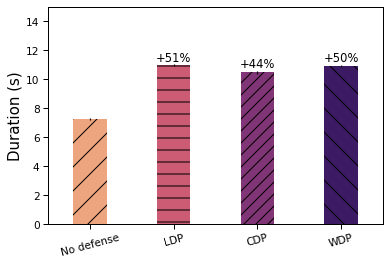

0    0.061562
1    0.060835
2    0.061860
Name: server_aggregation_duration, dtype: float64
[0.06141893068949377]
0    0.032622
1    0.033967
2    0.032912
Name: server_aggregation_duration, dtype: float64
[0.0331671237945556]
0    27.261351
1    26.367051
2    26.144810
Name: server_aggregation_duration, dtype: float64
[26.591070810953777]
0    0.040648
1    0.032612
2    0.037666
Name: server_aggregation_duration, dtype: float64
[0.036975383758544866]
[61.41893068949377, 33.1671237945556, 26591.070810953777, 36.975383758544865]
[0.5270265385966801, 0.7080642050475775, 591.0199388892198, 4.062405144124898]
61 ± 0
33 ± 0
26591 ± 591
36 ± 4


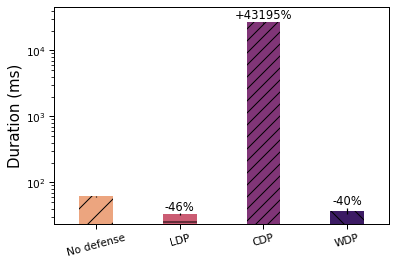

0    0.061562
1    0.060835
2    0.061860
Name: server_aggregation_duration, dtype: float64
[0.06141893068949377]
0    0.032622
1    0.033967
2    0.032912
Name: server_aggregation_duration, dtype: float64
[0.0331671237945556]
0    27.261351
1    26.367051
2    26.144810
Name: server_aggregation_duration, dtype: float64
[26.591070810953777]
0    0.040648
1    0.032612
2    0.037666
Name: server_aggregation_duration, dtype: float64
[0.036975383758544866]
[2301, 2499, 2501, 2499]
[0, 0, 0, 0]
2301 ± 0
2499 ± 0
2501 ± 0
2499 ± 0


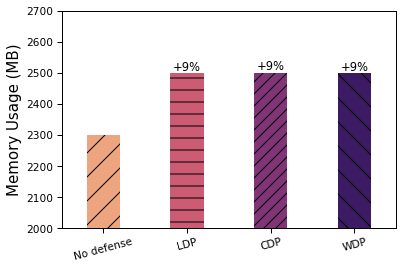

In [78]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 15, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale='log')
values = [2301, 2499, 2501, 2499]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 2000, 2700, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)


In [60]:
plot_config = {
                "dataset_name": "costs_cifar_vgg",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_cifar100_vgg.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costscosts_cdp_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_cifar100_vgg.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

In [ ]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", 0, 25, average=True, decimals=2)
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000)


In [61]:
plot_config = {
                "dataset_name": "costs_cifar100_resnet",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_cifar100_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs/costs_cdp_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_cifar100_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    7.188055
1    7.392974
2    6.857160
Name: client_round_duration_2, dtype: float64
0    7.358210
1    7.134408
2    7.586651
Name: client_round_duration_0, dtype: float64
0    7.874032
1    7.700781
2    7.012411
Name: client_round_duration_1, dtype: float64
0    7.943984
1    7.208416
2    7.130472
Name: client_round_duration_4, dtype: float64
0    7.371122
1    7.588954
2    7.082904
Name: client_round_duration_3, dtype: float64
[7.146062850952148, 7.359756390253703, 7.529074986775716, 7.427623987197876, 7.3476598262786865]
0    10.628846
1    10.921285
2    10.489518
Name: client_round_duration_2, dtype: float64
0    10.993790
1    10.991728
2    10.971708
Name: client_round_duration_0, dtype: float64
0    11.118599
1    10.751493
2    10.742895
Name: client_round_duration_1, dtype: float64
0    11.260869
1    11.093885
2    11.375663
Name: client_round_duration_4, dtype: float64
0    10.765558
1    10.986295
2    11.010784
Name: client_round_duration_3, dtype: float64
[10.6798

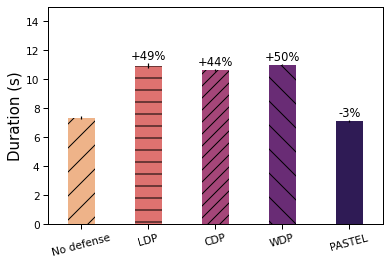

0    0.061655
1    0.063279
2    0.059933
Name: server_aggregation_duration, dtype: float64
[0.0616223812103271]
0    0.035004
1    0.033940
2    0.036039
Name: server_aggregation_duration, dtype: float64
[0.0349944432576497]
0    26.986475
1    27.019103
2    26.569938
Name: server_aggregation_duration, dtype: float64
[26.858505407969158]
0    0.038379
1    0.040701
2    0.032520
Name: server_aggregation_duration, dtype: float64
[0.03720005353291827]
0    0.057552
1    0.061155
2    0.059764
Name: server_aggregation_duration, dtype: float64
[0.0594905217488606]
[61.6223812103271, 34.9944432576497, 26858.505407969158, 37.20005353291827, 59.4905217488606]
[1.6732258007119756, 1.0495489512696206, 250.43888781978947, 4.216132986059622, 1.8171272850962032]
61 ± 1
34 ± 1
26858 ± 250
37 ± 4
59 ± 1


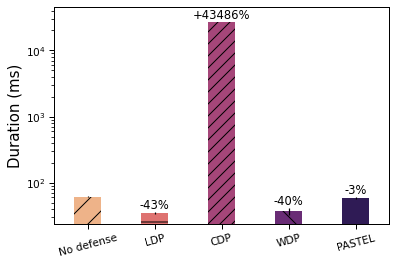

0    0.061655
1    0.063279
2    0.059933
Name: server_aggregation_duration, dtype: float64
[0.0616223812103271]
0    0.035004
1    0.033940
2    0.036039
Name: server_aggregation_duration, dtype: float64
[0.0349944432576497]
0    26.986475
1    27.019103
2    26.569938
Name: server_aggregation_duration, dtype: float64
[26.858505407969158]
0    0.038379
1    0.040701
2    0.032520
Name: server_aggregation_duration, dtype: float64
[0.03720005353291827]
0    0.057552
1    0.061155
2    0.059764
Name: server_aggregation_duration, dtype: float64
[0.0594905217488606]
[2307, 2523, 2527, 2523, 2307]
[0, 0, 0, 0, 0]
2307 ± 0
2523 ± 0
2527 ± 0
2523 ± 0
2307 ± 0


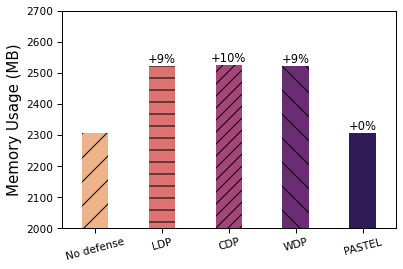

In [62]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", min_y=0, max_y=15, average=True, decimals=2, y_scale='None')
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale ='log')
values = [2307, 2523, 2527, 2523, 2307]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 2000, 2700, average=True, decimals=2, factor=1000, display_err = False,  manual_values=values)


In [63]:
plot_config = {
                "dataset_name": "costs_speechcommands",
                "dataset_pretty_name" : "cifar100_resnet",

                "data":[

                        {
                            "exp_name" : "No defense",
                            "file_path": "costs_baseline_speech_commands_resnet.csv",
                            "color": "black",
                            "symbol" : "+"
                        },
                        {
                            "exp_name" : "LDP",
                            "file_path": "costs_ldp_speech_commands_resnet.csv",
                            "color": "grey",
                            "symbol" : "*"
                        },
              {
                            "exp_name" : "CDP",
                            "file_path": "costs/costs_cdp_speech_commands_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                                            {
                            "exp_name" : "WDP",
                            "file_path": "costs_wdp_speech_commands_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                              
                                                                {
                            "exp_name" : "PASTEL",
                            "file_path": "costs_pastel_speech_commands_resnet.csv",
                            "color": "grey",
                            "symbol" : "^"
                        },
                    
                    ]
                }

0    19.251556
1    18.658177
2    19.222947
Name: client_round_duration_3, dtype: float64
0    18.980196
1    18.908071
2    18.673934
Name: client_round_duration_1, dtype: float64
0    19.230196
1    18.826758
2    18.756876
Name: client_round_duration_2, dtype: float64
0    18.846664
1    18.835824
2    18.906216
Name: client_round_duration_0, dtype: float64
0    19.057822
1    18.619179
2    18.598716
Name: client_round_duration_4, dtype: float64
[19.04422688484192, 18.854067007700603, 18.93794322013855, 18.862901369730633, 18.758572657903034]
0    23.995947
1    23.681623
2    23.722628
Name: client_round_duration_3, dtype: float64
0    23.931412
1    23.850870
2    23.708452
Name: client_round_duration_1, dtype: float64
0    23.867896
1    23.760924
2    23.838821
Name: client_round_duration_2, dtype: float64
0    23.888315
1    23.719302
2    23.788689
Name: client_round_duration_0, dtype: float64
0    23.732018
1    23.845868
2    23.766289
Name: client_round_duration_4, dtype:

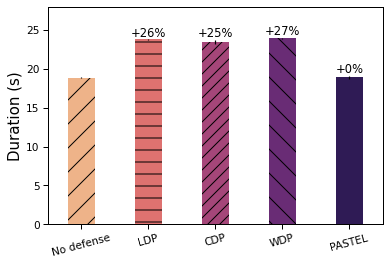

0    0.288410
1    0.394386
2    0.282910
Name: server_aggregation_duration, dtype: float64
[0.32190219561258954]
0    0.232950
1    0.368916
2    0.267461
Name: server_aggregation_duration, dtype: float64
[0.2897757689158121]
0    23.013685
1    22.543402
2    22.444796
Name: server_aggregation_duration, dtype: float64
[22.667294184366863]
0    0.269994
1    0.228112
2    0.273766
Name: server_aggregation_duration, dtype: float64
[0.2572910785675048]
0    0.289624
1    0.287912
2    0.705240
Name: server_aggregation_duration, dtype: float64
[0.4275921980539958]
[321.90219561258954, 289.7757689158121, 22667.294184366863, 257.2910785675048, 427.5921980539958]
[62.83326763488665, 70.67621757503366, 304.007580460019, 25.339701194299632, 240.45137684800034]
321 ± 62
289 ± 70
22667 ± 304
257 ± 25
427 ± 240


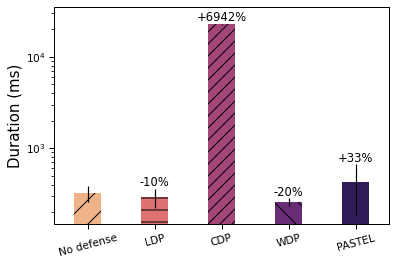

0    0.288410
1    0.394386
2    0.282910
Name: server_aggregation_duration, dtype: float64
[0.32190219561258954]
0    0.232950
1    0.368916
2    0.267461
Name: server_aggregation_duration, dtype: float64
[0.2897757689158121]
0    23.013685
1    22.543402
2    22.444796
Name: server_aggregation_duration, dtype: float64
[22.667294184366863]
0    0.269994
1    0.228112
2    0.273766
Name: server_aggregation_duration, dtype: float64
[0.2572910785675048]
0    0.289624
1    0.287912
2    0.705240
Name: server_aggregation_duration, dtype: float64
[0.4275921980539958]
[18667, 33253, 33289, 33253, 18667]
[0, 0, 0, 0, 0]
18667 ± 0
33253 ± 0
33289 ± 0
33253 ± 0
18667 ± 0


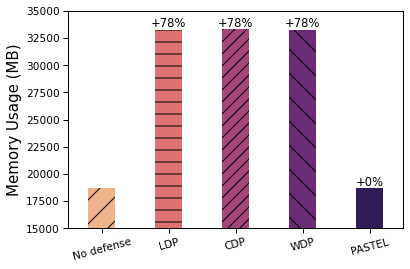

In [64]:
generate_histogram(plot_config, "hist_client_round_duration", "Duration (s)", "client_round_duration", min_y=0, max_y=28, average=True, decimals=2, y_scale='None')
generate_histogram(plot_config, "hist_server_aggregation_duration", "Duration (ms)", "server_aggregation_duration", 10, 33, average=True, decimals=2, factor=1000, y_scale ='log')
values = [18667, 33253, 33289, 33253, 18667]
generate_histogram(plot_config, "hist_memory_usage", "Memory Usage (MB)", "server_aggregation_duration", 15000, 35000, average=True, decimals=2, factor=1000, display_err=False,  manual_values=values)
